In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-cub-dataset/CUB_200_2011.tgz


In [ ]:
!tar -xvzf /kaggle/input/cnn-cub-dataset/CUB_200_2011.tgz

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, GlobalMaxPooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
import shutil
from tensorflow.keras.models import Model

In [22]:
# Create 'train' and 'test' directories
train_dir = 'train'
test_dir = 'test'

# Check if directories already exist; if not, create them
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

print(f'Directories {train_dir} and {test_dir} created successfully.')

Directories train and test created successfully.


In [23]:
images_file = 'CUB_200_2011/images.txt'
classes_file = 'CUB_200_2011/classes.txt'
image_class_labels_file = 'CUB_200_2011/image_class_labels.txt'
train_test_split_file = 'CUB_200_2011/train_test_split.txt'

# Read each file into a dataframe
images_df = pd.read_csv(images_file, sep=' ', header=None, names=['image_id', 'image_name'])
classes_df = pd.read_csv(classes_file, sep=' ', header=None, names=['class_id', 'class_name'])
image_class_labels_df = pd.read_csv(image_class_labels_file, sep=' ', header=None, names=['image_id', 'class_id'])
train_test_split_df = pd.read_csv(train_test_split_file, sep=' ', header=None, names=['image_id', 'is_training_image'])

In [24]:
# Merge images_df with image_class_labels_df on 'image_id'
merged_df = pd.merge(images_df, image_class_labels_df, on='image_id')

# Merge the result with train_test_split_df on 'image_id'
merged_df = pd.merge(merged_df, train_test_split_df, on='image_id')

# Merge the result with classes_df on 'class_id'
merged_df = pd.merge(merged_df, classes_df, on='class_id')

# Display the first few rows of the merged dataframe to verify
print(merged_df.head())

   image_id                                         image_name  class_id  \
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...         1   
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...         1   

   is_training_image                  class_name  
0                  0  001.Black_footed_Albatross  
1                  1  001.Black_footed_Albatross  
2                  0  001.Black_footed_Albatross  
3                  1  001.Black_footed_Albatross  
4                  1  001.Black_footed_Albatross  


In [25]:
def create_class_subdirectories(base_dir, class_names):
    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

# Get the list of class and image names from the classes dataframe
class_names = classes_df['class_name'].tolist()
image_names = images_df['image_name'].tolist()
# Create subdirectories in the train directory
create_class_subdirectories('train', class_names)

# Create subdirectories in the test directory
create_class_subdirectories('test', class_names)

print(f'Subdirectories for each class created in "train" and "test" directories.')

Subdirectories for each class created in "train" and "test" directories.


In [26]:
images_dir = 'CUB_200_2011/images'
filtered_df_train = merged_df[merged_df['is_training_image'] == 1]
filtered_train=filtered_df_train['image_name'].tolist()
filtered_df_test = merged_df[merged_df['is_training_image'] == 0]
filtered_test=filtered_df_test['image_name'].tolist()
def move_images(base_dir, image_name):
    src_image_path = os.path.join(images_dir, image_name)  
    dst_image_path = os.path.join(base_dir, image_name)
    if os.path.exists(src_image_path):
        shutil.copy(src_image_path, dst_image_path)
    else:
        print(f"Warning: {src_image_path} does not exist")
# Move training images
for training_image in filtered_train:
     move_images(train_dir, training_image)

# Move testing images
for testing_image in filtered_test:
    move_images(test_dir, testing_image)

print("Images have been successfully organized.")

Images have been successfully organized.


In [27]:
checkpoint_dir = '/kaggle/working/model_checkpoints'

# Create checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Print the directory path for confirmation
print(f"Checkpoint directory: {checkpoint_dir}")

# List contents of the directory before saving
print("Contents of checkpoint directory before saving:")
print(os.listdir(checkpoint_dir))

Checkpoint directory: /kaggle/working/model_checkpoints
Contents of checkpoint directory before saving:
[]


In [44]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=0,
    validation_split=0.1,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
val_data=tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=0,
    validation_split=0.1,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=0,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 5994 files belonging to 200 classes.
Using 5395 files for training.
Found 5994 files belonging to 200 classes.
Using 599 files for validation.
Found 5794 files belonging to 200 classes.


In [36]:
train_data=train_data.map(lambda x, y: (x/255, y))
test_data=test_data.map(lambda x, y: (x/255, y))

Epoch 1/100
  1/169 ━━━━━━━━━━━━━━━━━━━━ 1:15:57 27s/step - accuracy: 0.0000e+00 - loss: 5.4511

W0000 00:00:1721972376.857039     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1367 - loss: 4.5753

W0000 00:00:1721972399.537530     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721972404.899384     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


169/169 ━━━━━━━━━━━━━━━━━━━━ 59s 189ms/step - accuracy: 0.1373 - loss: 4.5711 - val_accuracy: 0.4558 - val_loss: 2.6723
Epoch 2/100
  2/169 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.7109 - loss: 2.2187 

W0000 00:00:1721972408.534875     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6264 - loss: 2.1427 - val_accuracy: 0.5743 - val_loss: 1.9720
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.7473 - loss: 1.4062 - val_accuracy: 0.6010 - val_loss: 1.6991
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8278 - loss: 1.0461 - val_accuracy: 0.6344 - val_loss: 1.5602
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8595 - loss: 0.8253 - val_accuracy: 0.6394 - val_loss: 1.4783
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8911 - loss: 0.6880 - val_accuracy: 0.6444 - val_loss: 1.4341
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9093 - loss: 0.5831 - val_accuracy: 0.6544 - val_loss: 1.3941
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9270 - loss: 0.5045 - val_accuracy: 0.6427 - val_loss: 1.3633
Epoch 9/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9419 - loss: 0.4370 - val_accuracy

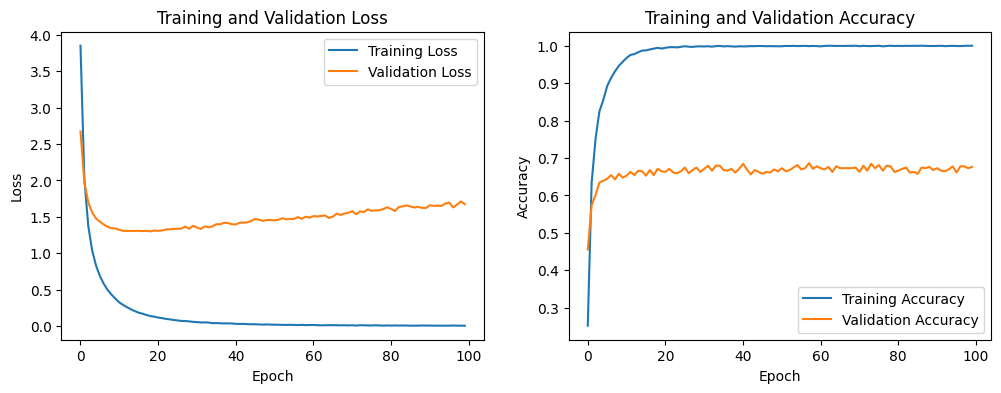

In [45]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(224, 224, 3),
                                            include_top=False,
                                            weights='imagenet')


for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(200, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras')
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
history = model.fit(train_data, epochs=100, validation_data=val_data)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [48]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test accuracy:', test_accuracy*100.0,'%')

182/182 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.6863 - loss: 1.5168
Test accuracy: 68.12219619750977 %


In [ ]:
model.summary()

In [50]:
final_model_path = os.path.join(checkpoint_dir, 'final_model.keras')
model.save(checkpoint_path)
model.save(final_model_path)
print(f'Final model saved to {final_model_path}')

Final model saved to /kaggle/working/model_checkpoints/final_model.keras
